In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 576.2MB 19kB/s 


In [0]:
!pip install fastai

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# %cd gdrive/My Drive/images

/content/gdrive/My Drive/images


In [13]:
# %cd ..

/content


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import torch.nn as nn
import cv2

In [0]:
t = Path('./gdrive/My Drive/images/train/')
c = Path('./gdrive/My Drive/images/people_crops/')

In [0]:
!pwd

/content


In [0]:
# images/train/chain_id/hotel_id/data_source/image_id.jpg
def extract_train(limit=False):
    data = []
    i = 0
    for chain_id in t.ls():
        for hotel_id in chain_id.ls():
            for d_source in hotel_id.ls():
                for image_id in d_source.ls():
                    i += 1
                    data.append([chain_id.name, 
                                 hotel_id.name, 
                                 d_source.name, 
                                 image_id.name,
                                 str(image_id)])
                    if limit and i > 2000:
                        return data
                      
def extract_occlusions(limit=False):
    data, i = [], 0
    for ci in c.ls():
        i += 1
        data.append([ci.name,
                    str(ci)])
        if limit and i > 2000:
            return data

In [0]:
data = extract_train(limit=True)
occ = extract_occlusions(limit=True)

In [0]:
data_df = pd.DataFrame(data, columns=['chain_id',
                              'hotel_id',
                              'd_source',
                              'image_id',
                              'path'])

occ_df = pd.DataFrame(occ, columns=['occlusion_id', 'path'])

In [20]:
data_df.head()

,chain_id,hotel_id,d_source,image_id,path
0,3,18187,traffickcam,3485.jpg,gdrive/My Drive/images/train/3/18187/traffickc...
1,3,18187,traffickcam,3486.jpg,gdrive/My Drive/images/train/3/18187/traffickc...
2,3,18187,travel_website,1192035.jpg,gdrive/My Drive/images/train/3/18187/travel_we...
3,3,18187,travel_website,1192037.jpg,gdrive/My Drive/images/train/3/18187/travel_we...
4,3,18187,travel_website,1192039.jpg,gdrive/My Drive/images/train/3/18187/travel_we...


In [21]:
occ_df.head()

,occlusion_id,path
0,8820.png,gdrive/My Drive/images/people_crops/8820.png
1,14392.png,gdrive/My Drive/images/people_crops/14392.png
2,348.png,gdrive/My Drive/images/people_crops/348.png
3,25629.png,gdrive/My Drive/images/people_crops/25629.png
4,29013.png,gdrive/My Drive/images/people_crops/29013.png


In [0]:
# apply occlusions to training images
def _occlusion(x):
#     if np.random.uniform() < .5:
    if True:
        x = apply_occlusion(x)
    return x
occlusion = TfmPixel(_occlusion)

In [0]:
def apply_occlusion(img, occlusion_idx=None, scale_resize=1.):
    img_c, img_h, img_w = img.shape
    
    # load occlusion
    # TODO: optimize for faster imread + uniform sampling across crops
    occ_idx = np.random.randint(len(occ_df)) if not occlusion_idx else occlusion_idx
    occ_path = occ_df.loc[occ_idx].path 
    occ = cv2.imread(occ_path)

    # random resize taking up < 80% of image 
    while True:
        resized_occ = cv2.resize(occ, (0, 0),
                               fx=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4), 
                               fy=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4))
        percent_filled = np.sum(resized_occ[:, :, 0] // 255) / (img_h * img_w)
        h, w, _ = resized_occ.shape
    
        if percent_filled < 0.8 and h < img_h and w < img_w: 
            occ_mask = (1 - resized_occ // 255)
            break
    
    # get info 
    occ_h, occ_w, _ = occ_mask.shape
    d_height = img_h - occ_h 
    d_width = img_w - occ_w
    
    # random placement 
    p_top = np.random.uniform() 
    p_left = np.random.uniform() 
    top_fill = int(d_height * p_top)
    bottom_fill = d_height - top_fill
    left_fill = int(d_width * p_left)
    right_fill = d_width - left_fill
    
    fit_occ_mask = cv2.copyMakeBorder(occ_mask, top_fill, bottom_fill, left_fill, right_fill, cv2.BORDER_CONSTANT)
    tensor_occ_mask = torch.from_numpy(1 - fit_occ_mask[:, :, 0]).type(torch.float)

    return tensor_occ_mask * img

Tried some series of data augmentation:

In [0]:
batch_size = 16
img_size = 224
ds_tfms = get_transforms(max_rotate=35, max_zoom=1.4, max_lighting=0.2, max_warp=0.4, p_affine=1.0, p_lighting=1.0, xtra_tfms=[occlusion()])
label_col = 1 # hotel_id


# If the class has only 1 image, we want it to be in the train-set.
# TODO Fix: https://forums.fast.ai/t/kaggle-humpback-whale-identification/35934
data = ImageDataBunch.from_df('.', 
                              data_df, 
                              label_col=label_col,
                              fn_col=-1, 
                              ds_tfms=ds_tfms, 
                              size=img_size,
                              padding_mode = 'zeros',
                              bs=batch_size)

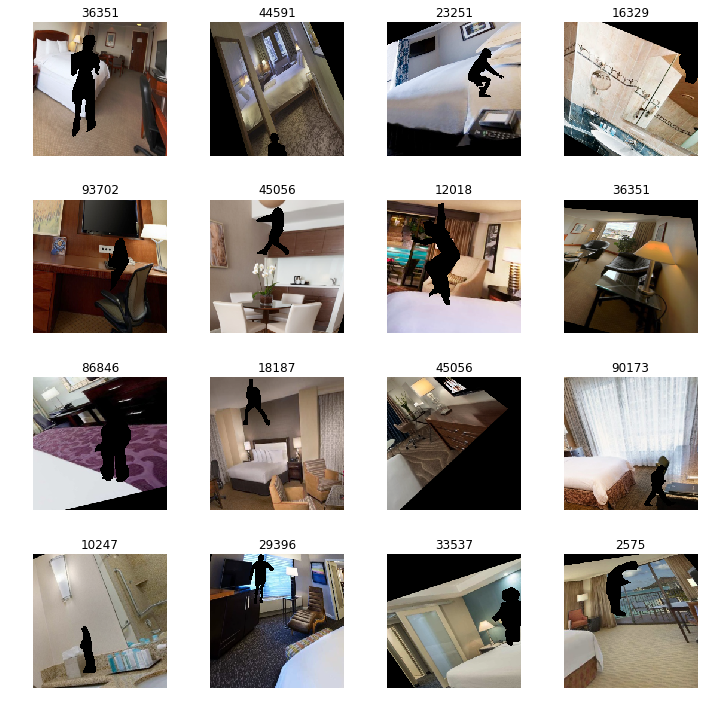

In [25]:
data.show_batch(rows=5, figsize=(10, 10))

In [28]:
data.classes

['100140',
 '10199',
 '10247',
 '10328',
 '103458',
 '105573',
 '11025',
 '11131',
 '11544',
 '11581',
 '11725',
 '12018',
 '12586',
 '13377',
 '1379',
 '139325',
 '13977',
 '14234',
 '1438',
 '15353',
 '15483',
 '15526',
 '16047',
 '16082',
 '16329',
 '16677',
 '16784',
 '17791',
 '17826',
 '17886',
 '18031',
 '18187',
 '18612',
 '18750',
 '19191',
 '19236',
 '19388',
 '19588',
 '2012',
 '20455',
 '21573',
 '21800',
 '22026',
 '23211',
 '23251',
 '23480',
 '23872',
 '2431',
 '24316',
 '25684',
 '2575',
 '26007',
 '26036',
 '26238',
 '26327',
 '26365',
 '26975',
 '27439',
 '28363',
 '28527',
 '28994',
 '29396',
 '30755',
 '30934',
 '30999',
 '31242',
 '31264',
 '31395',
 '31677',
 '32050',
 '32382',
 '32516',
 '32813',
 '33537',
 '3359',
 '3371',
 '34389',
 '34587',
 '35626',
 '35774',
 '36062',
 '36351',
 '37701',
 '38039',
 '38168',
 '3987',
 '40675',
 '40743',
 '41333',
 '43247',
 '43418',
 '43599',
 '43739',
 '44591',
 '45056',
 '47649',
 '48020',
 '50512',
 '50643',
 '5174',
 '521

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:45<00:00, 1906205.95it/s]


In [27]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,5.287125,4.642796,0.917500,05:03
1,4.568082,4.069656,0.835000,00:42
2,4.007825,3.955581,0.805000,00:42


In [0]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


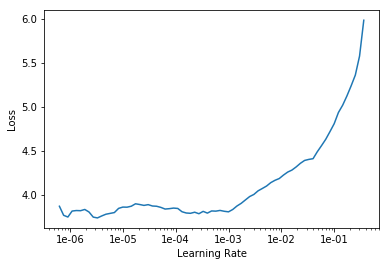

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, 1e-05)

epoch,train_loss,valid_loss,error_rate,time
0,3.912003,3.918557,0.815000,00:43
1,3.779957,3.819247,0.780000,00:43
2,3.750185,3.806851,0.775000,00:43
